In [1]:
!pwd

/mnt/home/eneubeck/GADME/Quantus


# 1) What is Quantus?

Quantus ist ein  Open-Source-Toolkit für (XAI)
Bewertet die XAI Erklärungen
Vergleicht die verschiedenen XAI Methoden

## 1.2 Beschreibung Metriken 
    Faithfulness (↑) quantifiziert, inwieweit Erklärungen dem Vorhersageverhalten des Modells folgen, und prüft, ob wichtigere Merkmale die Modellentscheidungen stärker beeinflussen.
    Haben die Bereiche auf dem Spektrogramm, die von den XAI-Methoden hervorgehoben werden, tatsächlich einen starken Einfluss auf die Modellvorhersage?

    Robustness (↓)  misst, inwieweit Erklärungen stabil sind, wenn die Eingaben sich leicht verändern, unter der Annahme, dass die Modellausgabe annähernd gleich bleibt.
    Wenn das Spektrogramm leicht gestört wird (z.B. durch Hinzufügen von geringem Rauschen) und die hervorgehobenen wichtigen Merkmale sich stark ändern, wäre das ein Zeichen für geringe Robustheit.

    Complexity (↓) erfasst, inwieweit Erklärungen prägnant sind, d.h., dass wenige Merkmale verwendet werden, um eine Modellvorhersage zu erklären
    Wenn die XAI-Methode nur wenige, aber prägnante Bereiche im Spektrogramm als wichtig identifiziert, ist das ein Zeichen für geringe Komplexität

    Randomisation (↑, ↓) testet, inwieweit Erklärungen sich verschlechtern, wenn die Labels oder das Modell, z.B. die Modell-Parameter, zunehmend randomisiert werden
    Wenn die Labels der Vogelstimmen zufällig vertauscht werden und die Erklärungen der XAI-Methode sich stark ändern, zeigt das, dass die ursprünglichen Erklärungen sinnvoll waren. Wenn die Erklärungen sich nicht ändern, könnte das bedeuten, dass sie nicht wirklich auf den spezifischen Daten basieren.

    Localisation (↑) testet, ob die Erklärung um einen Bereich zentriert ist. Dieser Bereich kann durch eine Bounding Box, eine Segmentation Mask oder eine Zelle eines Gitters definiert werden
    Wenn die XAI-Methode wichtige Bereiche um bestimmte Zeit-Frequenz-Bereiche herum konzentriert, die Vogelstimmen enthalten, ist das ein Zeichen für gute Lokalisation.

# 2) Installation prerequisites

In [2]:
# !pip install captum torchvision medmnist datasets transformers --quiet
# DEPRECATION: src 0.1.0 has a non-standard dependency specifier torch<3.0.0,>=2.0.1+cu117; sys_platform == "linux". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of src or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
# Get the latest versions of quantus and metaquantus.
# !pip install install git+https://github.com/understandable-machine-intelligence-lab/Quantus.git \
# git+https://github.com/annahedstroem/MetaQuantus.git --quiet
# DEPRECATION: src 0.1.0 has a non-standard dependency specifier torch<3.0.0,>=2.0.1+cu117; sys_platform == "linux". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of src or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

# !pip --version  # pip 23.3.1 from /mnt/home/eneubeck/.conda/envs/explai/lib/python3.10/site-packages/pip (python 3.10)
# !pip list --outdated  # src ist nicht outdated
# Fazit: so lange es funktioniert und so lange ich nicht auf pip 24.0 update, sollte es noch gehen, danach muss ich nochmal schauen

## 2.1. Imports

In [3]:
import sys
import os

# Absoluten Pfad zum Verzeichnis hinzufügen
module_path = '/mnt/home/eneubeck/GADME'
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# Imports from tutorial
import quantus
import metaquantus
import glob
import gc
import tqdm
import os
import copy
import warnings
import torch
import torchvision
import captum
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from birdset.datamodule.birdset_datamodule import BirdSetDataModule

# Enable GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Notebook settings.
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=FutureWarning)
sns.set()

!pip freeze > requirements_quantus.txt

In [383]:
# my imports
import json
import time
import librosa
import pickle

# 3) Preliminaries

## 3.1 Load data     

In [6]:
# Test Batches holen
eff_test_batch1 = torch.load('/mnt/home/eneubeck/GADME/XAI/eff_test_batch1.pth')
eff_test_batch2 = torch.load('/mnt/home/eneubeck/GADME/XAI/eff_test_batch2.pth')

### 3.1.1 eff_test_batch1_samples_np

In [287]:
# EfficientNet Test Batch 1 aufteilen in samples und true_labels aufteilen

# ein numpy.ndarray mit 64 examples:
# = x_batch im Tutorial:
eff_test_batch1_samples = eff_test_batch1["input_values"].unsqueeze(0)
eff_test_batch1_samples_np = np.squeeze(eff_test_batch1["input_values"].numpy())  # (64, 128, 1024)
eff_test_batch1_samples_np = eff_test_batch1_samples_np[:, np.newaxis, :, :]  # (64, 1, 128, 1024)


{0: [0], 1: [0], 14: [2], 18: [1], 19: [1, 2], 20: [2], 21: [1, 2], 22: [1, 2], 23: [2], 24: [1, 2], 30: [3], 31: [3], 46: [1, 3], 47: [1, 2], 48: [2], 49: [1, 2], 50: [2], 51: [1], 53: [1], 55: [1], 57: [1], 58: [1], 61: [1], 63: [1, 2]}


### 3.1.2 true_labels

In [ ]:
# ein Tensor mit 64 true_labels:
# = y_batch im Tutorial ?:
# Find the positions of ones in each row
eff_test_batch1_true_labels_tensors = (eff_test_batch1["labels"] == 1).nonzero(as_tuple=True)

# Group the indices by row
true_labels_by_row_dict = {}
for row, col in zip(eff_test_batch1_true_labels_tensors[0], eff_test_batch1_true_labels_tensors[1]):
    if row.item() not in true_labels_by_row_dict:
        true_labels_by_row_dict[row.item()] = []
    true_labels_by_row_dict[row.item()].append(col.item())

# Convert to list of lists
eff_test_batch1_true_labels = [true_labels_by_row_dict[i] if i in true_labels_by_row_dict else [] for i in range(eff_test_batch1["labels"].size(0))]

In [316]:
print(eff_test_batch1_true_labels)

[[0], [0], [], [], [], [], [], [], [], [], [], [], [], [], [2], [], [], [], [1], [1, 2], [2], [1, 2], [1, 2], [2], [1, 2], [], [], [], [], [], [3], [3], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [1, 3], [1, 2], [2], [1, 2], [2], [1], [], [1], [], [1], [], [1], [1], [], [], [1], [], [1, 2]]


In [289]:
print(true_labels_by_row_dict)

{0: [0], 1: [0], 14: [2], 18: [1], 19: [1, 2], 20: [2], 21: [1, 2], 22: [1, 2], 23: [2], 24: [1, 2], 30: [3], 31: [3], 46: [1, 3], 47: [1, 2], 48: [2], 49: [1, 2], 50: [2], 51: [1], 53: [1], 55: [1], 57: [1], 58: [1], 61: [1], 63: [1, 2]}


### 3.1.3 predicted_labels

In [8]:
# Laden der gespeicherten Vorhersagen von EfficientNet Test Batch 1

# die Vorhersage des Modells gibt einen output_sigmoid Tensor heraus
loaded_eff_test_batch1_output_sigmoid = torch.load('/mnt/home/eneubeck/GADME/XAI/eff_test_batch1_output_sigmoid.pt')  # torch.Size([64, 21])

# aus dem output_sigmoid wurden die höchsten Scores (die prediction_scores) und die Indexe der höchsten Scores (die predicted_labels) ermittelt 
loaded_eff_test_batch1_prediction_scores = torch.load('/mnt/home/eneubeck/GADME/XAI/eff_test_batch1_prediction_scores.pt')  # torch.Size([64])

# eff_test_batch1_samples_np
# = y_batch im Tutorial?:
loaded_eff_test_batch1_predicted_labels = torch.load('/mnt/home/eneubeck/GADME/XAI/eff_test_batch1_prediction_label_indexes.pt')  # torch.Size([64])

## 3.2 Load models

In [9]:
# EfficientNet Modell
# dauert kurz

# EfficientNetClassifier importieren
from birdset.modules.models.efficientnet import EfficientNetClassifier

# Definition der Parameter
num_classes = 21 # The number of classes for the output layer
num_channels = 1  # The number of input channels  # 1 für Für Graustufenbildern 
checkpoint_path = "../logs/train/runs/HSN/efficientnet/2024-04-25_140516/callback_checkpoints/efficientnet_HSN_32.ckpt"

efficientnet_model = EfficientNetClassifier(
    num_classes=num_classes,
    num_channels=num_channels,
    checkpoint = "google/efficientnet-b1",
    local_checkpoint=checkpoint_path)

efficientnet_model = efficientnet_model.eval()

print("done")

done


## 3.3 Load XAI methods IG, GS, Sal

### 3.3.0 Available XAI methods in Quantus von Captum

In [10]:
# View the XAI methods available for PyTorch users.
quantus.AVAILABLE_XAI_METHODS_CAPTUM

['GradientShap',
 'IntegratedGradients',
 'DeepLift',
 'DeepLiftShap',
 'InputXGradient',
 'Saliency',
 'FeatureAblation',
 'Deconvolution',
 'FeaturePermutation',
 'Lime',
 'KernelShap',
 'LRP',
 'Gradient',
 'Occlusion',
 'LayerGradCam',
 'GuidedGradCam',
 'LayerConductance',
 'LayerActivation',
 'InternalInfluence',
 'LayerGradientXActivation',
 'Control Var. Sobel Filter',
 'Control Var. Constant',
 'Control Var. Random Uniform']

In [382]:
from captum.attr import InputXGradient

# Anzeigen der Dokumentation
help(InputXGradient)

Help on class InputXGradient in module captum.attr._core.input_x_gradient:

class InputXGradient(captum.attr._utils.attribution.GradientAttribution)
 |  InputXGradient(forward_func: Callable) -> None
 |  
 |  A baseline approach for computing the attribution. It multiplies input with
 |  the gradient with respect to input.
 |  https://arxiv.org/abs/1605.01713
 |  
 |  Method resolution order:
 |      InputXGradient
 |      captum.attr._utils.attribution.GradientAttribution
 |      captum.attr._utils.attribution.Attribution
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, forward_func: Callable) -> None
 |      Args:
 |      
 |          forward_func (Callable): The forward function of the model or any
 |                        modification of it
 |  
 |  attribute(self, inputs: ~TensorOrTupleOfTensorsGeneric, target: Union[NoneType, int, Tuple[int, ...], torch.Tensor, List[Tuple[int, ...]], List[int]] = None, additional_forward_args: Any = None) -> ~Tensor

### 3.3.1 plot defs def show_spectrogram

In [11]:
#@title 3.3.1 Plotting single method
# %%capture

import numpy as np
import matplotlib.pyplot as plt

def plot_explanation(input_sample: np.array,
                     pred_name: str,
                     explanation: np.array,
                     img_size: tuple = (128, 1024),
                     normalise: bool = True,
                     denormalise: bool = False,
                     method: str = "Gradient"):
    """Plot an explanation for an input sample."""
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

    if denormalise:
        # ImageNet settings.
        image = (np.moveaxis(quantus.denormalise(input_sample,
                                             mean=np.array([0.485, 0.456, 0.406]),
                                             std=np.array([0.229, 0.224, 0.225])), 0, -1) * 255).astype(np.uint8)
    else:
        image = np.moveaxis(input_sample, 0, 2)

    if normalise:
        explanation = quantus.normalise_by_max(explanation)

    axes[0].imshow(image, vmin=0.0, vmax=1.0, cmap="viridis")
    axes[0].title.set_text(f"Prediction: {pred_name}")
    axes[0].axis("off")
    
    attr_ = axes[1].imshow(explanation.reshape(img_size), cmap="viridis")
    #fig.colorbar(attr_, ax=axes[1], fraction=0.05, pad=0.05)
    axes[1].title.set_text(method)
    axes[1].axis("off")

    plt.show()



In [251]:
def show_spectrogram(spektrum, sr= 32000 , hop_length=320 , \
                     n_fft=1024 , titel='Mel-Spektrogramm', cmap="viridis"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spektrum, 
                             y_axis='mel', sr=sr, hop_length=hop_length, n_fft=n_fft,  
                             x_axis='time', cmap=cmap)
    plt.colorbar(format='%+2.0f dB')
    plt.title(titel)
    plt.tight_layout()
    plt.show()

In [244]:
#quantus.explain?

### 3.3.2 define Random , the own XAI Explainer

In [139]:
# Or define your own XAI method.
# erzeugt einen Dummy-XAI Methode mit dem Namen your_own_random_explainer

def your_own_random_explainer(model: torch.nn,  # ein Modell aus der PyTorch-Bibliothek
                              inputs: np.array,
                              targets: np.array,
                              **kwargs):
    # nimmt ein Modell, Eingaben und Zielwerte sowie zusätzliche Argumente (kwargs) entgegen und gibt eine zufällige Erklärung zurück
    # Dummy explanation.
    size =  kwargs.get("size", ((len(inputs), 1, 224, 224))  # Größe der Ausgabe. Versucht, size aus den kwargs zu holen. Sonst wird Standardwert (15, 1, 224, 224) verwendet
    a_batch = np.random.random(size=size)  # erzeugt ein Numpy-Array a_batch mit zufälligen Werten zwischen 0 und 1 in der size.
    return a_batch


### 3.3.2 inspect XAI methods

In [452]:
eff_test_batch1_samples_np_63_expanded = np.expand_dims(eff_test_batch1_samples_np[63], axis=0)
eff_test_batch1_samples_np_63_expanded.shape

(1, 1, 128, 1024)

In [459]:
# Get base explanations.
# dauert

xai_quantus_base_method = quantus.explain(efficientnet_model, eff_test_batch1_samples_np, loaded_eff_test_batch1_predicted_labels)

#xai_base.shape

In [273]:
# Get IG explanations towards predicted labels
ig_kwargs = {"method": "IntegratedGradients", "xai_lib": "captum"}
xai_ig = quantus.explain(efficientnet_model, eff_test_batch1_samples_np, loaded_eff_test_batch1_predicted_labels, **ig_kwargs)

#xai_ig.shape

(64, 1, 128, 1024)

In [315]:
# TODO: # Get IG explanations towards true labels
"""
print(loaded_eff_test_batch1_predicted_labels)
print(eff_test_batch1_true_labels)

ig_kwargs = {"method": "IntegratedGradients", "xai_lib": "captum"}
xai_ig_true_labels = quantus.explain(efficientnet_model, eff_test_batch1_samples_np, eff_test_batch1_true_labels, **ig_kwargs)

#xai_ig_true_labels.shape
"""

'\nprint(loaded_eff_test_batch1_predicted_labels)\nprint(eff_test_batch1_true_labels)\n\nig_kwargs = {"method": "IntegratedGradients", "xai_lib": "captum"}\nxai_ig_true_labels = quantus.explain(efficientnet_model, eff_test_batch1_samples_np, eff_test_batch1_true_labels, **ig_kwargs)\n\n#xai_ig_true_labels.shape\n'

In [274]:
# Get GS explanations towards predicted labels
gs_kwargs = {"method": "GradientShap", "xai_lib": "captum"}
xai_gs = quantus.explain(efficientnet_model, eff_test_batch1_samples_np, loaded_eff_test_batch1_predicted_labels, **gs_kwargs)

#xai_gs.shape

(64, 1, 128, 1024)

In [453]:
# Get Lime explanations towards predicted labels
#dauert länger
start_time = time.time()
lime_kwargs = {"method": "Lime", "xai_lib": "captum"}
xai_lime_63 = quantus.explain(efficientnet_model, eff_test_batch1_samples_np_63_expanded, loaded_eff_test_batch1_predicted_labels[63], **lime_kwargs)

xai_lime_63.shape
end_time = time.time()
execution_time = end_time - start_time
print(f"execution_time: {execution_time} seconds")

(1, 1, 128, 1024)

In [455]:
"""
# Get FeaturePermutation explanations towards predicted labels
#dauert länger, braucht batch >1 :cannot permute features with batch_size = 1
fp_kwargs = {"method": "FeaturePermutation", "xai_lib": "captum"}
xai_fp_63 = quantus.explain(efficientnet_model, eff_test_batch1_samples_np_63_expanded, loaded_eff_test_batch1_predicted_labels[63], **fp_kwargs)

xai_fp_63.shape
"""

'\n# Get FeaturePermutation explanations towards predicted labels\n#dauert länger, braucht batch >1 :cannot permute features with batch_size = 1\nfp_kwargs = {"method": "FeaturePermutation", "xai_lib": "captum"}\nxai_fp_63 = quantus.explain(efficientnet_model, eff_test_batch1_samples_np_63_expanded, loaded_eff_test_batch1_predicted_labels[63], **fp_kwargs)\n\nxai_fp_63.shape\n'

In [456]:
# Get InputXGradient explanations towards predicted labels
ix_kwargs = {"method": "InputXGradient", "xai_lib": "captum"}
xai_ix = quantus.explain(efficientnet_model, eff_test_batch1_samples_np, loaded_eff_test_batch1_predicted_labels, **ix_kwargs)

xai_ix.shape

(64, 1, 128, 1024)

In [275]:
# Get Saliency explanations towards predicted labels
sal_kwargs = {"method": "Saliency", "xai_lib": "captum"}
xai_sal = quantus.explain(efficientnet_model, eff_test_batch1_samples_np, loaded_eff_test_batch1_predicted_labels, **sal_kwargs)

#xai_sal.shape

(64, 1, 128, 1024)

In [290]:
# show dict of true samples to choose a sample from
print(true_labels_by_row_dict)

{0: [0], 1: [0], 14: [2], 18: [1], 19: [1, 2], 20: [2], 21: [1, 2], 22: [1, 2], 23: [2], 24: [1, 2], 30: [3], 31: [3], 46: [1, 3], 47: [1, 2], 48: [2], 49: [1, 2], 50: [2], 51: [1], 53: [1], 55: [1], 57: [1], 58: [1], 61: [1], 63: [1, 2]}


true label(s):  [1, 2]
predicted label:  tensor(1)


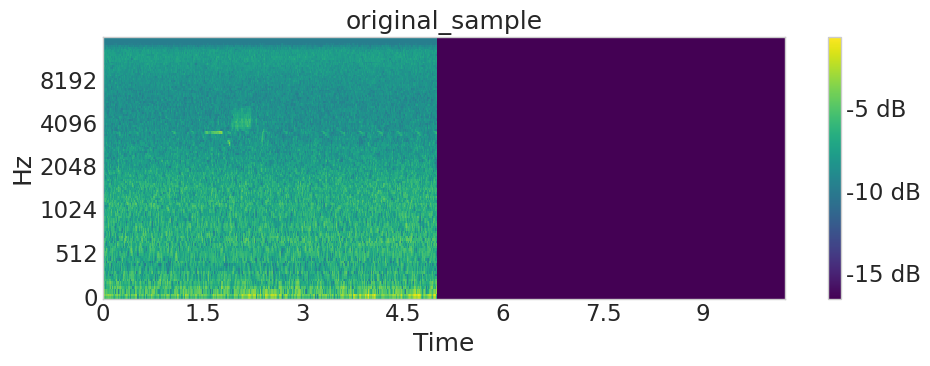

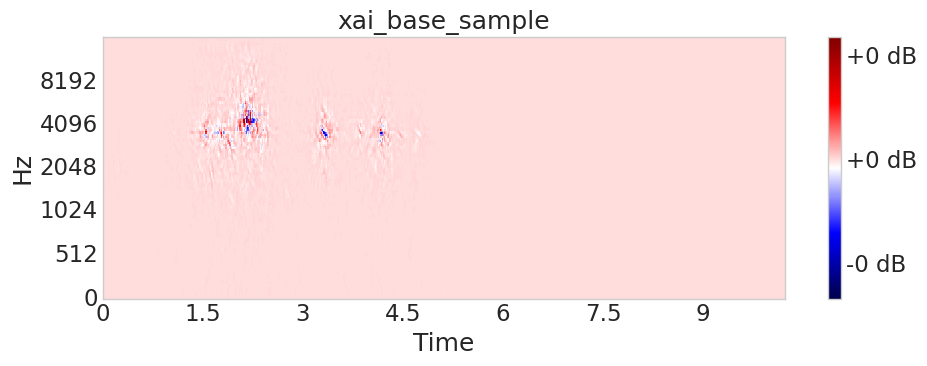

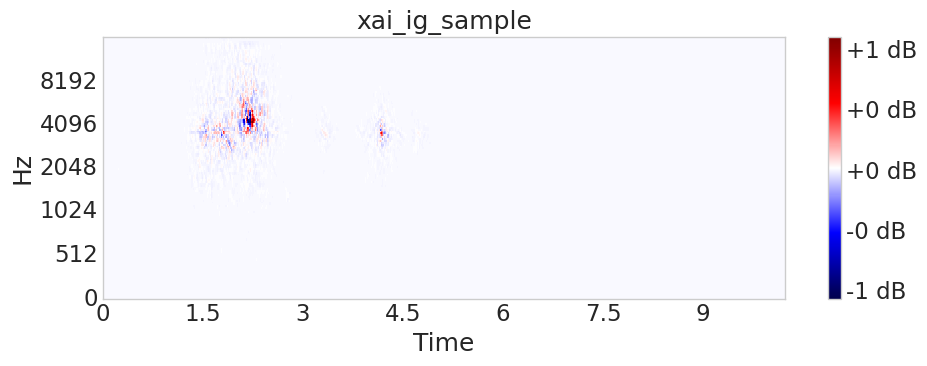

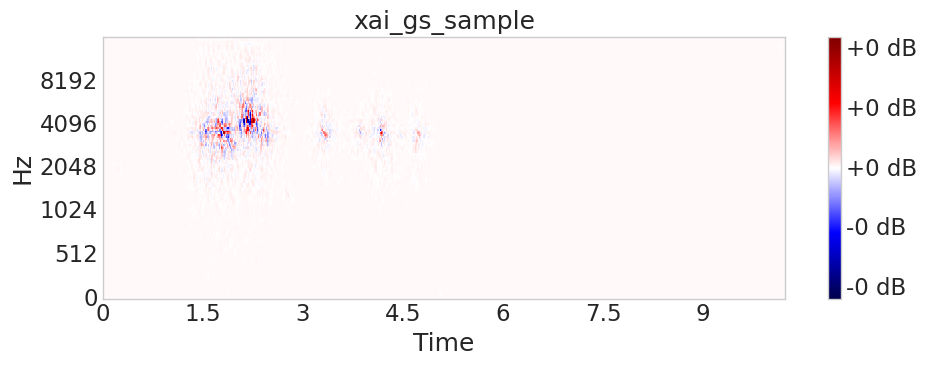

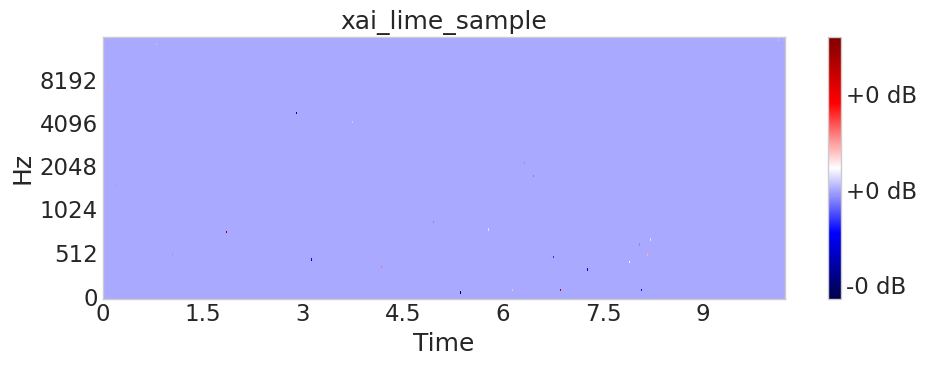

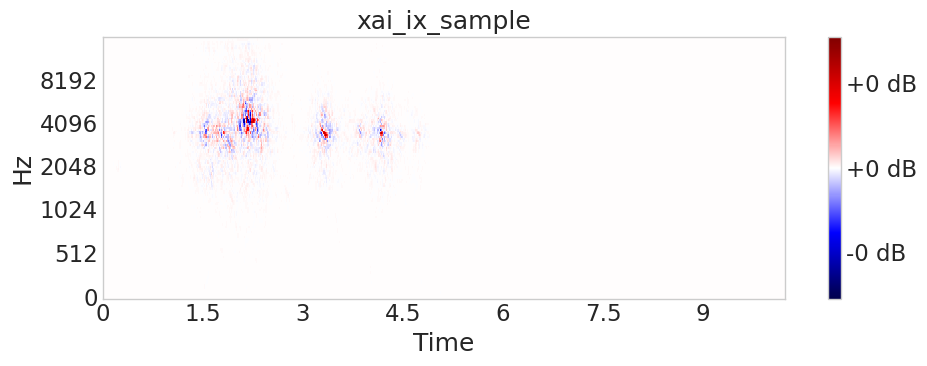

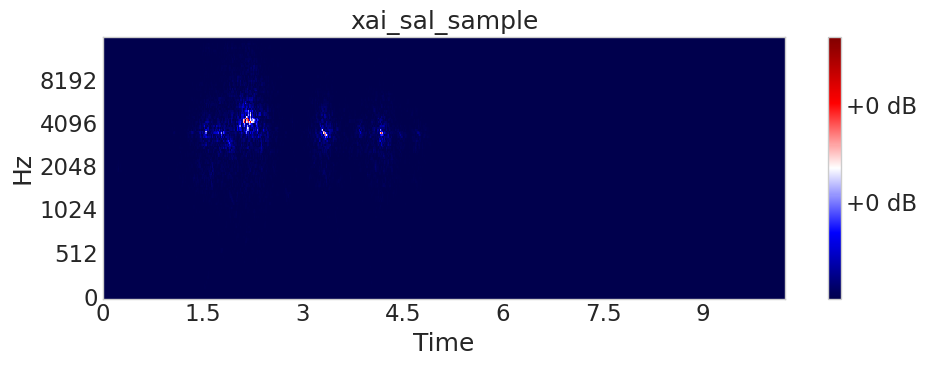

In [460]:
# pick a sample
spectrogram_index = 63

original_sample = np.squeeze(eff_test_batch1_samples_np[spectrogram_index])

xai_quantus_base_method_sample = np.squeeze(xai_quantus_base_method[spectrogram_index])
xai_ig_sample = np.squeeze(xai_ig[spectrogram_index])
xai_gs_sample = np.squeeze(xai_gs[spectrogram_index])
xai_lime_sample = np.squeeze(xai_lime_63)
xai_ix_sample = np.squeeze(xai_ix[spectrogram_index])
xai_sal_sample = np.squeeze(xai_sal[spectrogram_index])

# show
print("true label(s): ", true_labels_by_row_dict[spectrogram_index])
print("predicted label: ", loaded_eff_test_batch1_predicted_labels[spectrogram_index])

show_spectrogram(original_sample, titel='original_sample')
show_spectrogram(xai_base_sample, titel='xai_base_sample', cmap = "seismic")
show_spectrogram(xai_ig_sample, titel='xai_ig_sample', cmap = "seismic")
show_spectrogram(xai_gs_sample, titel='xai_gs_sample', cmap = "seismic")
show_spectrogram(xai_lime_sample, titel='xai_lime_sample', cmap = "seismic")
show_spectrogram(xai_ix_sample, titel='xai_ix_sample', cmap = "seismic")
show_spectrogram(xai_sal_sample, titel='xai_sal_sample', cmap = "seismic")

## 3.4 Preparations

### 3.4.1 x_batch, y_batch

In [318]:
# to choose samples without no-label:
print(true_labels_by_row_dict)

{0: [0], 1: [0], 14: [2], 18: [1], 19: [1, 2], 20: [2], 21: [1, 2], 22: [1, 2], 23: [2], 24: [1, 2], 30: [3], 31: [3], 46: [1, 3], 47: [1, 2], 48: [2], 49: [1, 2], 50: [2], 51: [1], 53: [1], 55: [1], 57: [1], 58: [1], 61: [1], 63: [1, 2]}


In [352]:
# todo: delete

"""

# create batch with 1 sample

# Gegebene Indizes für ein einzelnes Beispiel
index_1 = 0

# Initialisierung der einzelnen Batch-Arrays für NumPy
x_batch_1 = eff_test_batch1_samples_np[index_1]
x_batch_1 = x_batch_1[np.newaxis, :, :, :]  # Hinzufügen einer neuen Achse für die Batch-Dimension

# Falls du mit PyTorch Tensoren arbeitest
x_batch_torch_1 = torch.tensor(eff_test_batch1_samples[index_1])
x_batch_torch_1 = x_batch_torch_1.unsqueeze(0)  # Hinzufügen einer neuen Achse für die Batch-Dimension

# Initialisierung von y_batch_1
y_batch_1 = eff_test_batch1_true_labels[index_1]


print(x_batch_1.shape)  # Überprüfen der Form von x_batch_1
print(len(y_batch_1))  # Überprüfen der Länge von y_batch_1
print(y_batch_1)  # Überprüfen der Inhalte von y_batch_1
print(x_batch_torch_1.shape)  # Überprüfen der Form von x_batch_torch_1


# Sicherstellen, dass y_batch_1 die richtige Form hat
if isinstance(y_batch_1, list):
    y_batch_1 = np.array(y_batch_1)
if y_batch_1.ndim == 1:
    y_batch_1 = y_batch_1[np.newaxis, :]  # Hinzufügen einer neuen Achse für die Batch-Dimension
elif y_batch_1.ndim == 0:
    y_batch_1 = np.array([y_batch_1])  # Umwandeln in ein Array und Hinzufügen einer neuen Achse

print(x_batch_1.shape)  # Überprüfen der Form von x_batch_1
print(len(y_batch_1))  # Überprüfen der Länge von y_batch_1
print(y_batch_1)  # Überprüfen der Inhalte von y_batch_1
print(x_batch_torch_1.shape)  # Überprüfen der Form von x_batch_torch_1
"""

(1, 1, 128, 1024)
1
[0]
torch.Size([1, 64, 1, 128, 1024])
(1, 1, 128, 1024)
1
[[0]]
torch.Size([1, 64, 1, 128, 1024])


In [354]:
# create batch with 1 sample

# Gegebene Indizes für ein einzelnes Beispiel
index_1 = 0

# Initialisierung der einzelnen Batch-Arrays für NumPy
x_batch_1 = eff_test_batch1_samples_np[index_1][np.newaxis, :, :, :]

# Falls du mit PyTorch Tensoren arbeitest
x_batch_torch_1 = torch.tensor(eff_test_batch1_samples[index_1]).unsqueeze(0)

# Initialisierung von y_batch_1 und Umwandlung in die richtige Form
y_batch_1 = np.array(eff_test_batch1_true_labels[index_1])[np.newaxis, :]

# Überprüfen der Formen und Inhalte
print(x_batch_1.shape)  # Überprüfen der Form von x_batch_1
print(y_batch_1.shape)  # Überprüfen der Form von y_batch_1
print(y_batch_1)  # Überprüfen der Inhalte von y_batch_1
print(x_batch_torch_1.shape)  # Überprüfen der Form von x_batch_torch_1

(1, 1, 128, 1024)
(1, 1)
[[0]]
torch.Size([1, 64, 1, 128, 1024])


In [338]:
# TODO delete
"""
# create batch with 10 samples 

# picked 10 indices without no-label
indices_10 = [0, 1, 14, 18, 20, 23, 30, 31, 48, 50]

# Initialisierung des NumPy-Arrays mit Nullen
x_batch_10 = np.zeros((len(indices_10), eff_test_batch1_samples_np.shape[1], eff_test_batch1_samples_np.shape[2], eff_test_batch1_samples_np.shape[3]))
# Füllen des NumPy-Arrays mit den ausgewählten Samples
for i, index in enumerate(indices_10):
    x_batch_10[i] = eff_test_batch1_samples_np[index]

# Initialisierung des PyTorch-Tensors mit Nullen
x_batch_torch_10 = torch.zeros((len(indices_10), eff_test_batch1_samples_np.shape[1], eff_test_batch1_samples_np.shape[2], eff_test_batch1_samples_np.shape[3]))
# Füllen des PyTorch-Tensors mit den ausgewählten Samples
for i, index in enumerate(indices):
    x_batch_torch_10[i] = torch.tensor(eff_test_batch1_samples_np[index])

# Erstellen einer Liste für die Batch-Labels:
y_batch_10 = []
for index in indices:
    y_batch_10.append(eff_test_batch1_true_labels[index])

print(x_batch_10.shape)  # Überprüfen der Form von x_batch_10
print(len(y_batch_10))  # Überprüfen der Länge von y_batch_10
print(y_batch_10)  # Überprüfen der Inhalte von y_batch_10
print(x_batch_torch_10.shape)  # Überprüfen der Form von x_batch_torch_10
"""

(10, 1, 128, 1024)
10
[[0], [0], [2], [1], [1, 2], [2], [1, 2], [1, 2], [2], [1, 2]]
torch.Size([10, 1, 128, 1024])


In [365]:
# TODO. delete

"""
# Gegebene Indizes für 10 Beispiele
indices_10 = [0, 1, 14, 18, 20, 23, 30, 31, 48, 50]

# Initialisierung des NumPy-Arrays mit den ausgewählten Samples
x_batch_10 = np.zeros((len(indices_10), eff_test_batch1_samples_np.shape[1], eff_test_batch1_samples_np.shape[2], eff_test_batch1_samples_np.shape[3]))
for i, index in enumerate(indices_10):
    x_batch_10[i] = eff_test_batch1_samples_np[index]

# Initialisierung des PyTorch-Tensors mit den ausgewählten Samples
x_batch_torch_10 = torch.zeros((len(indices_10), eff_test_batch1_samples_np.shape[1], eff_test_batch1_samples_np.shape[2], eff_test_batch1_samples_np.shape[3]))
for i, index in enumerate(indices_10):
    x_batch_torch_10[i] = torch.tensor(eff_test_batch1_samples_np[index])

# Erstellen einer Liste für die Batch-Labels
y_batch_10 = []
for index in indices_10:
    y_batch_10.append(eff_test_batch1_true_labels[index])

# Konvertieren von y_batch_10 in ein NumPy-Array
y_batch_10 = np.array([label if isinstance(label, list) else [label] for label in y_batch_10])

# Sicherstellen, dass die Labels die richtige Form haben
if y_batch_10.ndim == 1:
    y_batch_10 = y_batch_10[:, np.newaxis]
elif y_batch_10.ndim == 0:
    y_batch_10 = np.array([y_batch_10])

print(x_batch_10.shape)  # Überprüfen der Form von x_batch_10
print(type(y_batch_10), y_batch_10.shape)  # Überprüfen der Länge von y_batch_10
# print(y_batch_10)  # Überprüfen der Inhalte von y_batch_10
# print(x_batch_torch_10.shape)  # Überprüfen der Form von x_batch_torch_10

"""

(10, 1, 128, 1024)
<class 'numpy.ndarray'> (10, 1)
torch.Size([10, 1, 128, 1024])


In [ ]:
# TODO. delete
"""
# create batch with 10 samples 

# picked 10 indices without no-label
indices_10 = [0, 1, 14, 18, 20, 23, 30, 31, 48, 50]

# Initialisierung des NumPy-Arrays mit den ausgewählten Samples
x_batch_10 = np.zeros((len(indices_10), eff_test_batch1_samples_np.shape[1], eff_test_batch1_samples_np.shape[2], eff_test_batch1_samples_np.shape[3]))
for i, index in enumerate(indices_10):
    x_batch_10[i] = eff_test_batch1_samples_np[index]

# Initialisierung des PyTorch-Tensors mit den ausgewählten Samples
x_batch_torch_10 = torch.zeros((len(indices_10), eff_test_batch1_samples_np.shape[1], eff_test_batch1_samples_np.shape[2], eff_test_batch1_samples_np.shape[3]))
for i, index in enumerate(indices_10):
    x_batch_torch_10[i] = torch.tensor(eff_test_batch1_samples_np[index])

# Erstellen einer Liste für die Batch-Labels
y_batch_10 = []
for index in indices_10:
    y_batch_10.append(eff_test_batch1_true_labels[index])

# Konvertieren von y_batch_10 in ein NumPy-Array
y_batch_10 = np.array([label if isinstance(label, list) else [label] for label in y_batch_10])

# Sicherstellen, dass die Labels die richtige Form haben
if y_batch_10.ndim == 1:
    y_batch_10 = y_batch_10[:, np.newaxis]
elif y_batch_10.ndim == 0:
    y_batch_10 = np.array([y_batch_10])

# Hier wird y_batch_10 in die erwartete Form gebracht
# Statt One-Hot-Encoding verwenden wir die Klasse als Index
y_batch_10_corrected = y_batch_10.flatten()

# Konvertieren in PyTorch-Tensor
y_batch_10_corrected = torch.tensor(y_batch_10_corrected, dtype=torch.long)

#print("metrics",metrics)
#print("xai_methods_with_kwargs",xai_methods_with_kwargs)
print("x_batch_10", type(x_batch_10), x_batch_10.shape)
print("y_batch_10_corrected", type(y_batch_10_corrected), y_batch_10_corrected.shape)
"""

In [386]:
# Create batch with 10 samples
# Picked 10 indices without no-label
indices_10 = [0, 1, 14, 18, 20, 23, 30, 31, 48, 50]

# Initialize NumPy array with selected samples
x_batch_10 = np.array([eff_test_batch1_samples_np[index] for index in indices_10])

# Initialize PyTorch tensor with selected samples
x_batch_10_torch = torch.tensor(x_batch_10)

# Create a list for batch labels
y_batch_10 = [eff_test_batch1_true_labels[index] for index in indices_10]
# Convert y_batch_10 to a NumPy array and ensure correct shape
y_batch_10 = np.array([label if isinstance(label, list) else [label] for label in y_batch_10]).flatten()

# Convert to PyTorch tensor
y_batch_10_torch = torch.tensor(y_batch_10, dtype=torch.long)

# Print shapes for verification
print("x_batch_10", type(x_batch_10), x_batch_10.shape)
print("y_batch_10_torch", type(y_batch_10_torch), y_batch_10_torch.shape)

x_batch_10 <class 'numpy.ndarray'> (10, 1, 128, 1024)
y_batch_10_torch <class 'torch.Tensor'> torch.Size([10])


### 3.4.2 dict xai_methods_with_kwargs

In [ ]:
# Prepare dictionary with explanation methods and hyperparameters.
# Occlusion dauert für 1 sample > 5000s
xai_methods_with_kwargs ={
    # "Occlusion": {"strides": (1,8,8), "sliding_window_shapes": (1,15, 15), "baselines": -15},  # dauert sehr lange
    # "Occlusion": {},
    "Saliency": {},
    "GradientShap": {"n_samples":50, "stdevs":0.0001, "baselines":torch.cat([x_batch_torch_1 * 0, x_batch_torch_1 * 1])},
    "IntegratedGradients": {"n_steps": 200},
}

### 3.4.3 dict explanations

In [307]:
# Populate explanation in the dictionary.
explanations = {}
for method, kwargs in xai_methods_with_kwargs.items():
    a_batch = quantus.explain(
        model=efficientnet_model,
        inputs=x_batch_1,
        targets=y_batch_1,
        **{**{"method": method, "xai_lib": "captum"}, **kwargs}
    )
    explanations[method] = a_batch
    print(f"{method} - {a_batch.shape}")

Saliency - (1, 1, 128, 1024)
GradientShap - (1, 1, 128, 1024)
IntegratedGradients - (1, 1, 128, 1024)


In [306]:
explanations.keys()

dict_keys(['Saliency', 'GradientShap', 'IntegratedGradients'])

In [305]:
# add Random to explanations dict
# explanations["Random"] = your_own_random_explainer(model=efficientnet_model, inputs=x_batch_1, targets=y_batch_1, **{"size": (len(x_batch_1), 1, 128, 1024)})
# explanations["Random"]

# 4) Introduction to Quantus


We answer the following research question:

    RQ: Without ground truth (or medical expertise), what explanation method to choose to help understand the black box model?



## 4.1 Quantus Metrics

### 4.1.0  Available Metrics for the Categories (Groups of Metrics) in Quantus

In [141]:
# In each category of explanation quality, let's view the available metrics.
for k, v in quantus.AVAILABLE_METRICS.items():
    print(k)
    for i in v:
        print(f"\t• {i}")

Faithfulness
	• Faithfulness Correlation
	• Faithfulness Estimate
	• Pixel-Flipping
	• Region Segmentation
	• Monotonicity-Arya
	• Monotonicity-Nguyen
	• Selectivity
	• SensitivityN
	• IROF
	• ROAD
	• Infidelity
	• Sufficiency
Robustness
	• Continuity Test
	• Local Lipschitz Estimate
	• Max-Sensitivity
	• Avg-Sensitivity
	• Consistency
	• Relative Input Stability
	• Relative Output Stability
	• Relative Representation Stability
Localisation
	• Pointing Game
	• Top-K Intersection
	• Relevance Mass Accuracy
	• Relevance Rank Accuracy
	• Attribution Localisation 
	• AUC
	• Focus
Complexity
	• Sparseness
	• Complexity
	• Effective Complexity
Randomisation
	• MPRT
	• Smooth MPRT
	• Efficient MPRT
	• Random Logit
Axiomatic
	• Completeness
	• NonSensitivity
	• InputInvariance


### 4.1.1 PixelFlipping Metric for the Category Faithfulness

In [142]:
# Let's try initialising one Faithfulness metric, called PixelFlipping.
quantus.PixelFlipping().get_params

{'abs': False,
 'normalise': True,
 'return_aggregate': False,
 'aggregate_func': <function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>,
 'normalise_func': <function quantus.functions.normalise_func.normalise_by_max(a: numpy.ndarray, normalise_axes: Optional[Sequence[int]] = None) -> numpy.ndarray>,
 'normalise_func_kwargs': {},
 '_disable_warnings': False,
 '_display_progressbar': False,
 'a_axes': None,
 'features_in_step': 1,
 'return_auc_per_sample': False,
 'perturb_func': functools.partial(<function baseline_replacement_by_indices at 0x7ff160d89ab0>, perturb_baseline='black')}

### 4.1.2 Sparseness Metric for the Category Complexity

In [143]:
# Let's try initialising one Complexity metric, called Sparseness.
quantus.Sparseness?

# The test asks that features that are truly predictive of the output F(x) should have significant contributions, and
# similarly, that irrelevant (or weakly-relevant) features should have negligible contributions.

Init signature:
quantus.Sparseness(
    abs: bool = True,
    normalise: bool = True,
    normalise_func: Optional[Callable[[numpy.ndarray], numpy.ndarray]] = None,
    normalise_func_kwargs: Optional[Dict[str, Any]] = None,
    return_aggregate: bool = False,
    aggregate_func: Optional[Callable] = None,
    default_plot_func: Optional[Callable] = None,
    disable_warnings: bool = False,
    display_progressbar: bool = False,
    **kwargs,
)
Docstring:     
Implementation of Sparseness metric by Chalasani et al., 2020.

Sparseness is quantified using the Gini Index applied to the vector of the absolute values of attributions. The
test asks that features that are truly predictive of the output F(x) should have significant contributions, and
similarly, that irrelevant (or weakly-relevant) features should have negligible contributions.

Assumptions:
    - Based on the implementation of the authors as found on the following link:
    <https://github.com/jfc43/advex/blob/master/DNN-Exper

In [144]:
quantus.Sparseness().get_params

{'abs': True,
 'normalise': True,
 'return_aggregate': False,
 'aggregate_func': <function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>, *, where=<no value>)>,
 'normalise_func': <function quantus.functions.normalise_func.normalise_by_max(a: numpy.ndarray, normalise_axes: Optional[Sequence[int]] = None) -> numpy.ndarray>,
 'normalise_func_kwargs': {},
 '_disable_warnings': False,
 '_display_progressbar': False,
 'a_axes': None}

In [145]:
# im tut: (15, 3, 224, 224)
x_batch_1.shape

(1, 1, 128, 1024)

In [146]:
# Sparseness Saliency
# Alternative 1. Evaluate the Saliency explanations in a one-liner - by calling the intialised metric.
#  gibt im tut eine Liste mit 15 (da x_batch 15 samples hat) Werten zurück
quantus.Sparseness()(model=efficientnet_model, x_batch=x_batch_1, y_batch=y_batch_1, a_batch=explanations["Saliency"])

[0.9199154700046098]

In [199]:
# Change some hyperparameters, get an aggregate score over several test samples.
quantus.Sparseness(return_aggregate=True, disable_warnings=True)\
(model=efficientnet_model, x_batch=x_batch_1, y_batch=y_batch_1, a_batch=explanations["Saliency"])


[0.9199154700046098]

In [200]:
# Sparseness GradientShap
quantus.Sparseness(return_aggregate=True, disable_warnings=True)\
(model=efficientnet_model, x_batch=x_batch_1, y_batch=y_batch_1, a_batch=explanations["GradientShap"])

[0.9182321270393217]

In [201]:
# Sparseness IntegratedGradients
quantus.Sparseness(return_aggregate=True, disable_warnings=True)\
(model=efficientnet_model, x_batch=x_batch_1, y_batch=y_batch_1, a_batch=explanations["IntegratedGradients"])


[0.9114905707601682]

In [211]:
# Score all methods iteratively.
for method, attr in explanations.items():
    #print(method)
    #print(attr)
    metric = quantus.Sparseness(return_aggregate=False, disable_warnings=True)
    scores = metric(model=efficientnet_model, x_batch=x_batch_1, y_batch=y_batch_1, a_batch=attr)
    #print(f" {method} - {np.mean(scores):.2f} ({np.std(scores):.2f})")
    print(f" {method} - {np.mean(scores)} ({np.std(scores)})")

 Saliency - 0.9199154700046098 (0.0)
 GradientShap - 0.9182321270393217 (0.0)
 IntegratedGradients - 0.9114905707601682 (0.0)
 Random - 0.33307772639302285 (0.0)


## 4.2 Large-scale evaluation

### 4.2.1 Choose Metrics

In [441]:
# Initialise the Quantus evaluation metrics.
metrics = {
    "Faithfulness: FaithfulnessCorrelation": quantus.FaithfulnessCorrelation(
        nr_runs=10,
        subset_size=224,
        perturb_baseline="black",
        perturb_func=quantus.baseline_replacement_by_indices,
        similarity_func=quantus.similarity_func.correlation_pearson,
        abs=True,
        normalise=True,
        normalise_func=quantus.normalise_by_max,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Robustness: MaxSensitivity": quantus.MaxSensitivity(
        nr_samples=10,
        lower_bound=0.2,
        norm_numerator=quantus.norm_func.fro_norm,
        norm_denominator=quantus.norm_func.fro_norm,
        perturb_func=quantus.perturb_func.uniform_noise,
        similarity_func=quantus.similarity_func.difference,
        abs=False,
        normalise=True,
        normalise_func=quantus.normalise_by_max,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    # Localisation (↑) is left out, as we do not have sagmentation masks
    
    "Complexity: Sparseness": quantus.Sparseness(
        abs=True,
        normalise=True,
        normalise_func=quantus.normalise_by_max,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    "Randomisation: EfficientMPRT": quantus.EfficientMPRT(
        similarity_func=quantus.similarity_func.correlation_spearman,
        abs=False,
        normalise=True,
        normalise_func=quantus.normalise_by_max,
        aggregate_func=np.mean,
        return_aggregate=True,
        disable_warnings=True,
    ),
    # Axiomatic is left out, because none of the metrics did work 
}

In [433]:
#print("x_batch_1 ",x_batch_1 )
#print("y_batch_1 ",y_batch_1 )
#print("efficientnet_model ",efficientnet_model )
#print("x_batch_torch_1 ",x_batch_torch_1 )

In [439]:
# Axiomatic	• Completeness	• NonSensitivity	• InputInvariance didnt work
"""
# Nur die Axiomatic Metrik
metrics_axiomatic = {
    "Axiomatic: NonSensitivity": quantus.NonSensitivity(
        abs=False,
        normalise=False,  # Normalisierung deaktiviert
        perturb_func=quantus.baseline_replacement_by_indices,
        perturb_func_kwargs={"perturb_baseline": "black"},
        return_aggregate=False,
        aggregate_func=np.mean,
        disable_warnings=True,
        display_progressbar=True
    ),
}

# Evaluate XAI methods
call_kwargs_empty = {"empty": {}}  # Leeres call_kwargs Dictionary hinzufügen

results_axiomatic = quantus.evaluate(metrics=metrics_axiomatic,
                                     xai_methods=xai_methods_with_kwargs,
                                     model=efficientnet_model.cpu(),
                                     x_batch=x_batch_1,
                                     y_batch=y_batch_1,
                                     agg_func=np.mean,
                                     explain_func_kwargs=None,
                                     call_kwargs=call_kwargs_empty,  # call_kwargs hinzufügen
                                     return_as_df=False,
                                     verbose=True)

print(results_axiomatic)
"""

'\n# Nur die Axiomatic Metrik\nmetrics_axiomatic = {\n    "Axiomatic: NonSensitivity": quantus.NonSensitivity(\n        abs=False,\n        normalise=False,  # Normalisierung deaktiviert\n        perturb_func=quantus.baseline_replacement_by_indices,\n        perturb_func_kwargs={"perturb_baseline": "black"},\n        return_aggregate=False,\n        aggregate_func=np.mean,\n        disable_warnings=True,\n        display_progressbar=True\n    ),\n}\n\n# Evaluate XAI methods\ncall_kwargs_empty = {"empty": {}}  # Leeres call_kwargs Dictionary hinzufügen\n\nresults_axiomatic = quantus.evaluate(metrics=metrics_axiomatic,\n                                     xai_methods=xai_methods_with_kwargs,\n                                     model=efficientnet_model.cpu(),\n                                     x_batch=x_batch_1,\n                                     y_batch=y_batch_1,\n                                     agg_func=np.mean,\n                                     explain_func_kwargs=No

In [440]:
#quantus.Completeness?

In [197]:
#quantus.RelevanceRankAccuracy?

In [153]:
# quantus.evaluate?

### 4.2.2 Run Quantification Analysis

In [309]:
#xai_methods_with_kwargs

In [387]:
#quantus.evaluate?

In [412]:
#print("metrics",metrics)
#print("xai_methods_with_kwargs",xai_methods_with_kwargs)
print("x_batch_1", type(x_batch_1), x_batch_1.shape)
print("y_batch_1", type(y_batch_1), y_batch_1.shape)

x_batch_1 <class 'numpy.ndarray'> (1, 1, 128, 1024)
y_batch_1 <class 'numpy.ndarray'> (1, 1)


In [442]:
# Run full quantification analysis 1 Sample!
# dauert

start_time = time.time()

# Evaluate XAI methods.
results = quantus.evaluate(metrics=metrics,
                           xai_methods=xai_methods_with_kwargs,
                           model=efficientnet_model.cpu(),
                           x_batch=x_batch_1,
                           y_batch=y_batch_1,
                           #s_batch=s_batch,
                           agg_func=np.mean,
                           explain_func_kwargs=None,
                           call_kwargs=None,
                           return_as_df=False,
                           verbose=True)

end_time = time.time()
execution_time = end_time - start_time
print(f"execution_time: {execution_time} seconds")
# 30 Sekunden bei 1 example

results

Evaluating Saliency explanations on Faithfulness: FaithfulnessCorrelation metric with call parameters: {}...
Evaluating Saliency explanations on Robustness: MaxSensitivity metric with call parameters: {}...
Evaluating Saliency explanations on Complexity: Sparseness metric with call parameters: {}...
Evaluating Saliency explanations on Randomisation: EfficientMPRT metric with call parameters: {}...
Evaluating GradientShap explanations on Faithfulness: FaithfulnessCorrelation metric with call parameters: {}...
Evaluating GradientShap explanations on Robustness: MaxSensitivity metric with call parameters: {}...
Evaluating GradientShap explanations on Complexity: Sparseness metric with call parameters: {}...
Evaluating GradientShap explanations on Randomisation: EfficientMPRT metric with call parameters: {}...
Evaluating IntegratedGradients explanations on Faithfulness: FaithfulnessCorrelation metric with call parameters: {}...
Evaluating IntegratedGradients explanations on Robustness: Max

{'Saliency': {'Faithfulness: FaithfulnessCorrelation': 0.4798897840650629,
  'Robustness: MaxSensitivity': 1.5635805130004883,
  'Complexity: Sparseness': 0.9199154700046098,
  'Randomisation: EfficientMPRT': 9.317315346016807},
 'GradientShap': {'Faithfulness: FaithfulnessCorrelation': -0.029614137858834794,
  'Robustness: MaxSensitivity': 2.037989377975464,
  'Complexity: Sparseness': 0.9199154700046098,
  'Randomisation: EfficientMPRT': 8.366431911457527},
 'IntegratedGradients': {'Faithfulness: FaithfulnessCorrelation': 0.6869968909864893,
  'Robustness: MaxSensitivity': 2.0239217281341553,
  'Complexity: Sparseness': 0.9199154700046098,
  'Randomisation: EfficientMPRT': 9.000793307512765}}

In [388]:
#print("metrics",metrics)
#print("xai_methods_with_kwargs",xai_methods_with_kwargs)
print("x_batch_10", type(x_batch_10), x_batch_10.shape)
print("y_batch_10_torch", type(y_batch_10_torch), y_batch_10_torch.shape)

x_batch_10 <class 'numpy.ndarray'> (10, 1, 128, 1024)
y_batch_10_torch <class 'torch.Tensor'> torch.Size([10])


In [375]:
# Run full quantification analysis, 10 Samples
# dauert
"""
start_time = time.time()

# Evaluate XAI methods.
results_10 = quantus.evaluate(metrics=metrics,
                           xai_methods=xai_methods_with_kwargs,
                           model=efficientnet_model.cpu(),
                           x_batch=x_batch_10,
                           y_batch=y_batch_10_torch,
                           #s_batch=s_batch,
                           agg_func=np.mean,
                           explain_func_kwargs=None,
                           call_kwargs=None,
                           return_as_df=False,
                           verbose=True)

end_time = time.time()
execution_time = end_time - start_time
print(f"execution_time: {execution_time} seconds")
# 420 Sekunden bei 1 example

# save results_10
with open('results_10.pkl', 'wb') as f:
    pickle.dump(results_10, f)

print("results_10 is saved")
results_10
"""

# load results_10
with open('results_10.pkl', 'rb') as f:
    loaded_results_10 = pickle.load(f)

print(loaded_results_10)

Evaluating Saliency explanations on Faithfulness: FaithfulnessCorrelation metric with call parameters: {}...
Evaluating Saliency explanations on Robustness: MaxSensitivity metric with call parameters: {}...
Evaluating Saliency explanations on Complexity: Sparseness metric with call parameters: {}...
Evaluating Saliency explanations on Randomisation: EfficientMPRT metric with call parameters: {}...
Evaluating Saliency explanations on Axiomatic: Completeness metric with call parameters: {}...


  0%|          | 0/1.0 [00:00<?, ?it/s]

Evaluating GradientShap explanations on Faithfulness: FaithfulnessCorrelation metric with call parameters: {}...
Evaluating GradientShap explanations on Robustness: MaxSensitivity metric with call parameters: {}...
Evaluating GradientShap explanations on Complexity: Sparseness metric with call parameters: {}...
Evaluating GradientShap explanations on Randomisation: EfficientMPRT metric with call parameters: {}...
Evaluating GradientShap explanations on Axiomatic: Completeness metric with call parameters: {}...


  0%|          | 0/1.0 [00:00<?, ?it/s]

Evaluating IntegratedGradients explanations on Faithfulness: FaithfulnessCorrelation metric with call parameters: {}...
Evaluating IntegratedGradients explanations on Robustness: MaxSensitivity metric with call parameters: {}...
Evaluating IntegratedGradients explanations on Complexity: Sparseness metric with call parameters: {}...
Evaluating IntegratedGradients explanations on Randomisation: EfficientMPRT metric with call parameters: {}...
Evaluating IntegratedGradients explanations on Axiomatic: Completeness metric with call parameters: {}...


  0%|          | 0/1.0 [00:00<?, ?it/s]

execution_time: 420.3010392189026 seconds


{'Saliency': {'Faithfulness: FaithfulnessCorrelation': -0.08416864799918447,
  'Robustness: MaxSensitivity': 1.5183807969093324,
  'Complexity: Sparseness': 0.9006517019626837,
  'Randomisation: EfficientMPRT': 15.23965339528301,
  'Axiomatic: Completeness': 0.0},
 'GradientShap': {'Faithfulness: FaithfulnessCorrelation': -0.03471585431688805,
  'Robustness: MaxSensitivity': 3.953917980194092,
  'Complexity: Sparseness': 0.9006517019626837,
  'Randomisation: EfficientMPRT': 14.689575841416058,
  'Axiomatic: Completeness': 0.0},
 'IntegratedGradients': {'Faithfulness: FaithfulnessCorrelation': 0.019520581003876835,
  'Robustness: MaxSensitivity': 3.849088931083679,
  'Complexity: Sparseness': 0.9006517019626837,
  'Randomisation: EfficientMPRT': 14.500454997076726,
  'Axiomatic: Completeness': 0.0}}

#### Fehlersuche: warum ist Complexity: Sparseness': 0.919915470004609 bei allen 3 Methoden gleich?

run am 27.5.24:
{'Saliency': {'Faithfulness: FaithfulnessCorrelation': 0.1276888977543396,
  'Robustness: MaxSensitivity': 1.5464104413986206,
  'Complexity: Sparseness': 0.9199154700046098,
  'Randomisation: EfficientMPRT': 9.317315346016807,
  'Axiomatic: Completeness': 0.0},
 'GradientShap': {'Faithfulness: FaithfulnessCorrelation': 0.06831857128482352,
  'Robustness: MaxSensitivity': 2.011392116546631,
  'Complexity: Sparseness': 0.9199154700046098,
  'Randomisation: EfficientMPRT': 9.131552219631073,
  'Axiomatic: Completeness': 0.0},
 'IntegratedGradients': {'Faithfulness: FaithfulnessCorrelation': -0.39862525241807345,
  'Robustness: MaxSensitivity': 1.9510188102722168,
  'Complexity: Sparseness': 0.9199154700046098,
  'Randomisation: EfficientMPRT': 9.000793307512765,
  'Axiomatic: Completeness': 0.0}

In [222]:
quantus.FaithfulnessCorrelation()(model=efficientnet_model, x_batch=x_batch_1, y_batch=y_batch_1, a_batch=explanations["Saliency"])

[-0.0203704843468947]

In [232]:
# wdh
sparesness_sal = quantus.Sparseness()(model=efficientnet_model, x_batch=x_batch_1, y_batch=y_batch_1, a_batch=explanations["Saliency"])
sparesness_gs = quantus.Sparseness()(model=efficientnet_model, x_batch=x_batch_1, y_batch=y_batch_1, a_batch=explanations["GradientShap"])
sparesness_ig = quantus.Sparseness()(model=efficientnet_model, x_batch=x_batch_1, y_batch=y_batch_1, a_batch=explanations["IntegratedGradients"])
print("sparesness_sal",sparesness_sal)
print("sparesness_gs",sparesness_gs)
print("sparesness_ig",sparesness_ig)

sparesness_sal [0.9199154700046098]
sparesness_gs [0.9182321270393217]
sparesness_ig [0.9114905707601682]


In [227]:
# wdh
quantus.Completeness()(model=efficientnet_model, x_batch=x_batch_1, y_batch=y_batch_1, a_batch=explanations["Saliency"])

[False]

In [356]:
#explanations

Grund scheint der a_batch zu sein, a_batch kommt bei der Einzelberechnung aus explanations

In [238]:
"""
# Define a custom explain function
def custom_explain_func(model, inputs, targets, method, **kwargs):
    return quantus.explain(model=model, inputs=inputs, targets=targets, method=method, **kwargs)

def evaluate_with_a_batch(metrics, xai_methods, model, x_batch, y_batch, agg_func=np.mean, explain_func_kwargs=None, call_kwargs=None, return_as_df=False, verbose=True):
    results = {}
    a_batches = {}

    for method, method_kwargs in xai_methods.items():
        # Berechnung der Attributionen
        a_batch = custom_explain_func(model=model, inputs=x_batch, targets=y_batch, method=method, **method_kwargs)
        a_batches[method] = a_batch
        
        if verbose:
            print(f"Evaluating {method} explanations...")

        method_results = {}
        for metric_name, metric in metrics.items():
            # Wrapper Funktion, um sicherzustellen, dass 'method' übergeben wird
            def explain_func_with_method(model, inputs, targets, **kwargs):
                return custom_explain_func(model, inputs, targets, method=method, **kwargs)

            if explain_func_kwargs:
                metric_results = metric(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=a_batch, explain_func=explain_func_with_method, explain_func_kwargs=method_kwargs, **explain_func_kwargs)
            else:
                metric_results = metric(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=a_batch, explain_func=explain_func_with_method, explain_func_kwargs=method_kwargs)

            if return_as_df:
                metric_results = pd.DataFrame(metric_results)

            if call_kwargs:
                method_results[metric_name] = agg_func(metric_results, **call_kwargs)
            else:
                method_results[metric_name] = agg_func(metric_results)

        results[method] = method_results

    if return_as_df:
        results = pd.DataFrame(results)

    return results, a_batches

# Ausführen der modifizierten Evaluierungsfunktion
start_time = time.time()

results, a_batches = evaluate_with_a_batch(
    metrics=metrics,
    xai_methods=xai_methods_with_kwargs,
    model=efficientnet_model.cpu(),
    x_batch=x_batch_1,
    y_batch=y_batch_1,
    agg_func=np.mean,
    explain_func_kwargs=None,
    call_kwargs=None,
    return_as_df=False,
    verbose=True
)

end_time = time.time()
execution_time = end_time - start_time
print(f"execution_time: {execution_time} seconds")

print("Ergebnisse:")
print(results)

print("\nAttributionen (a_batch):")
for method, a_batch in a_batches.items():
    print(f"{method}: {a_batch}")
"""

Evaluating Saliency explanations...


  0%|          | 0/1.0 [00:00<?, ?it/s]

Evaluating GradientShap explanations...


  0%|          | 0/1.0 [00:00<?, ?it/s]

Evaluating IntegratedGradients explanations...


  0%|          | 0/1.0 [00:00<?, ?it/s]

execution_time: 29.59580707550049 seconds
Ergebnisse:
{'Saliency': {'Faithfulness: FaithfulnessCorrelation': -0.3549322735447867, 'Robustness: MaxSensitivity': 0.2967189848423004, 'Complexity: Sparseness': 0.9199154700046098, 'Randomisation: EfficientMPRT': 9.317315346016807, 'Axiomatic: Completeness': 0.0}, 'GradientShap': {'Faithfulness: FaithfulnessCorrelation': 0.005897349329086556, 'Robustness: MaxSensitivity': 0.6697275042533875, 'Complexity: Sparseness': 0.9105345113841938, 'Randomisation: EfficientMPRT': 3.8109720927612956, 'Axiomatic: Completeness': 0.0}, 'IntegratedGradients': {'Faithfulness: FaithfulnessCorrelation': -0.6222254549250619, 'Robustness: MaxSensitivity': 0.25273597240448, 'Complexity: Sparseness': 0.9114905707601682, 'Randomisation: EfficientMPRT': 9.000793307512765, 'Axiomatic: Completeness': 0.0}}

Attributionen (a_batch):
Saliency: [[[[3.6248537e-05 5.4957818e-05 4.9231498e-05 ... 7.1112743e-05
    4.2283729e-05 7.1821082e-06]
   [2.0319772e-05 2.3205646e-05 

### Beschreibung Metriken (Wdh)
    Faithfulness (↑) quantifiziert, inwieweit Erklärungen dem Vorhersageverhalten des Modells folgen, und prüft, ob wichtigere Merkmale die Modellentscheidungen stärker beeinflussen.
    Haben die Bereiche auf dem Spektrogramm, die von den XAI-Methoden hervorgehoben werden, tatsächlich einen starken Einfluss auf die Modellvorhersage?

    Robustness (↓)  misst, inwieweit Erklärungen stabil sind, wenn die Eingaben sich leicht verändern, unter der Annahme, dass die Modellausgabe annähernd gleich bleibt.
    Wenn das Spektrogramm leicht gestört wird (z.B. durch Hinzufügen von geringem Rauschen) und die hervorgehobenen wichtigen Merkmale sich stark ändern, wäre das ein Zeichen für geringe Robustheit.

    Complexity (↓) erfasst, inwieweit Erklärungen prägnant sind, d.h., dass wenige Merkmale verwendet werden, um eine Modellvorhersage zu erklären
    Wenn die XAI-Methode nur wenige, aber prägnante Bereiche im Spektrogramm als wichtig identifiziert, ist das ein Zeichen für geringe Komplexität

    Randomisation (↑, ↓) testet, inwieweit Erklärungen sich verschlechtern, wenn die Labels oder das Modell, z.B. die Modell-Parameter, zunehmend randomisiert werden
    Wenn die Labels der Vogelstimmen zufällig vertauscht werden und die Erklärungen der XAI-Methode sich stark ändern, zeigt das, dass die ursprünglichen Erklärungen sinnvoll waren. Wenn die Erklärungen sich nicht ändern, könnte das bedeuten, dass sie nicht wirklich auf den spezifischen Daten basieren.

    Localisation (↑) testet, ob die Erklärung um einen Bereich zentriert ist. Dieser Bereich kann durch eine Bounding Box, eine Segmentation Mask oder eine Zelle eines Gitters definiert werden
    Wenn die XAI-Methode wichtige Bereiche um bestimmte Zeit-Frequenz-Bereiche herum konzentriert, die Vogelstimmen enthalten, ist das ein Zeichen für gute Lokalisation.

### 4.2.3 Scores

In [402]:
# Postprocessing of scores: to get how the different explanation methods rank across criteria.
results_agg = {}
for method in xai_methods_with_kwargs:
    #print(method)
    results_agg[method] = {}
    for metric, metric_func in metrics.items():
        #print(metric)
        #print(results[method])
        results_agg[method][metric] = np.mean(results[method][metric])

df = pd.DataFrame.from_dict(results_agg)
df = df.T.abs()
df
     

,Faithfulness: FaithfulnessCorrelation,Robustness: MaxSensitivity,Complexity: Sparseness,Randomisation: EfficientMPRT,Axiomatic: Completeness
Saliency,0.029621,1.512115,0.919915,9.317315,0.0
GradientShap,0.108771,2.100665,0.919915,6.753988,0.0
IntegratedGradients,0.018946,1.963995,0.919915,9.000793,0.0


In [403]:
# Postprocessing of scores: to get how the different explanation methods rank across criteria.
results_agg_10 = {}
for method in xai_methods_with_kwargs:
    results_agg_10[method] = {}
    for metric, metric_func in metrics.items():
        results_agg_10[method][metric] = np.mean(results_10[method][metric])

df = pd.DataFrame.from_dict(results_agg_10)
df = df.T.abs()
df
     

,Faithfulness: FaithfulnessCorrelation,Robustness: MaxSensitivity,Complexity: Sparseness,Randomisation: EfficientMPRT,Axiomatic: Completeness
Saliency,0.084169,1.518381,0.900652,15.239653,0.0
GradientShap,0.034716,3.953918,0.900652,14.689576,0.0
IntegratedGradients,0.019521,3.849089,0.900652,14.500455,0.0


To compare the different XAI methods, we normalise the metric scores between [0,1]and rank the scores from lowest to highest (i.e. the highest rank corresponds to best performance).

In [407]:
# score with ranking: 3.0 is best

# Take inverse ranking for Robustness, since lower is better.
df_normalised = df.loc[:, ~df.columns.isin(['Robustness'])].apply(lambda x: x / x.max())
df_normalised["Robustness: MaxSensitivity"] = df["Robustness: MaxSensitivity"].min()/df["Robustness: MaxSensitivity"].values
df_normalised_rank = df_normalised.rank()
df_normalised_rank     

,Faithfulness: FaithfulnessCorrelation,Robustness: MaxSensitivity,Complexity: Sparseness,Randomisation: EfficientMPRT,Axiomatic: Completeness
Saliency,3.0,3.0,2.0,3.0,NaN
GradientShap,2.0,1.0,2.0,2.0,NaN
IntegratedGradients,1.0,2.0,2.0,1.0,NaN


### 4.2.4 Spyder Plot

In [409]:
#@title 4.2.1 Create spyder plot
# %%capture

# Plotting specifics.
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

# Plotting configs.
sns.set(font_scale=1.5)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['ytick.labelleft'] = True
plt.rcParams['xtick.labelbottom'] = True

include_titles = True
include_legend = True

# Source code: https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html.

def spyder_plot(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.
    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default."""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default."""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, angles=None):
            self.set_thetagrids(angles=np.degrees(theta), labels=labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped."""
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)

                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)

    return theta
     

In [172]:
# plt.style.available

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (4).

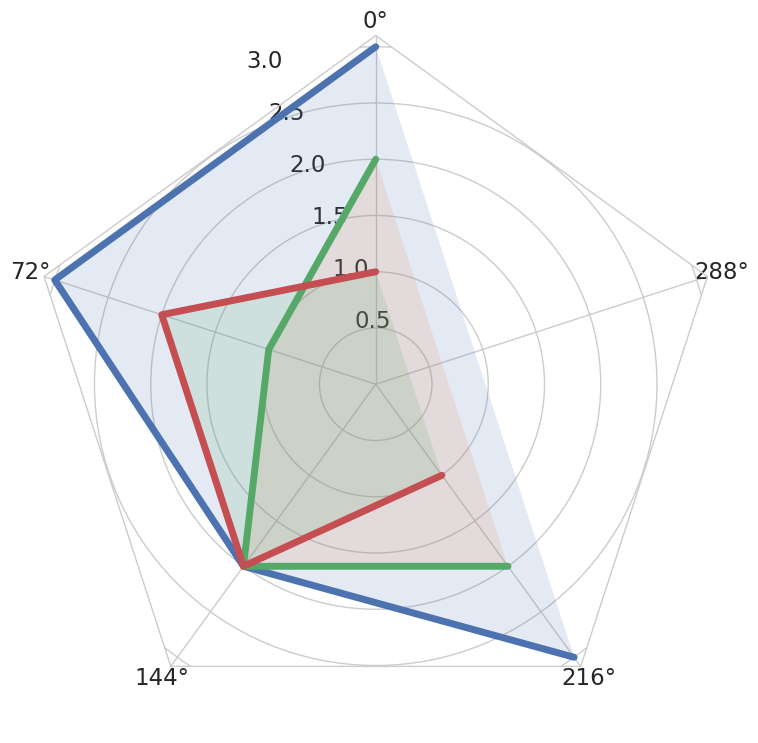

In [410]:
# batch with 1 sample 
# Make spyder graph!
data = [df_normalised_rank.columns.values, (df_normalised_rank.to_numpy())]
theta = spyder_plot(len(data[0]), frame='polygon')
spoke_labels = data.pop(0)
colours = ['b', 'g', 'r']

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)
for i, (d, method) in enumerate(zip(data[0], xai_methods_with_kwargs)):
    line = ax.plot(theta, d, label=method, color=colours[i], linewidth=5.0)
    ax.fill(theta, d, alpha=0.15)

# Set lables.
if include_titles:
    ax.set_varlabels(labels=['Faithfulness',
                             'Complexity',
                             'Sensitivity',
                             'Robustness']) #
else:
    ax.set_varlabels(labels=[])

ax.set_rgrids(np.arange(0, df_normalised_rank.values.max() + 0.5), labels=[])

# Set a title.
ax.set_title("Quantus: Summary of Quantification",  position=(0.5, 1.1), ha='center', fontsize=15)

# Put a legend to the right of the current axis.
if include_legend:
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

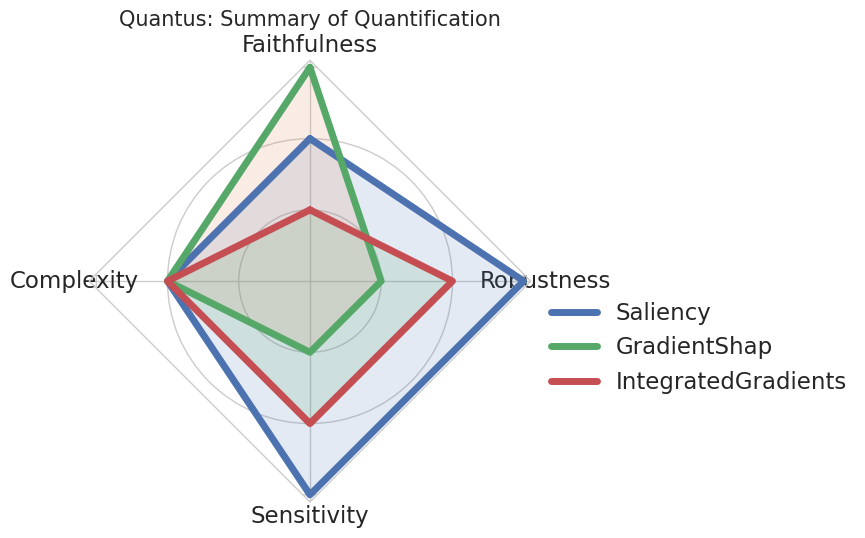

In [177]:
# batch with 10 samples 
# Make spyder graph!
data = [df_normalised_rank.columns.values, (df_normalised_rank.to_numpy())]
theta = spyder_plot(len(data[0]), frame='polygon')
spoke_labels = data.pop(0)
colours = ['b', 'g', 'r']

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)
for i, (d, method) in enumerate(zip(data[0], xai_methods_with_kwargs)):
    line = ax.plot(theta, d, label=method, color=colours[i], linewidth=5.0)
    ax.fill(theta, d, alpha=0.15)

# Set lables.
if include_titles:
    ax.set_varlabels(labels=['Faithfulness',
                             'Complexity',
                             'Sensitivity',
                             'Robustness']) #
else:
    ax.set_varlabels(labels=[])

ax.set_rgrids(np.arange(0, df_normalised_rank.values.max() + 0.5), labels=[])

# Set a title.
ax.set_title("Quantus: Summary of Quantification",  position=(0.5, 1.1), ha='center', fontsize=15)

# Put a legend to the right of the current axis.
if include_legend:
    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()